# Proyecto 03 - Sistema de recomendación de videojuegos en Steam

El objetivo del proyecto es crear un sistema de recomendación de videojuegos para la plataforma Steam, esto a partir de las reviews de los usuarios y los datos de los videojuegos.

## 0. Librerias y conformación de los datasets

In [1]:
# Importamos la librerías a utilizar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para optimizar el uso de la RAM
import gzip
import gc #garbage collector

# Librerías para la predicción - Surprise
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate

In [2]:
# Definimos una función para leer cada linea de los datos comprimidos
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
# Importar los datos de las caracteristicas de los juegos

# Función para abrir solo cada cierta cantidad de datos.
'''
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1
'''
# Funcion para coger solo una cantidad de datos en orden
data_games = []
num = 100000
for i, l in enumerate(parse('datos\steam_games.json.gz')):
    data_games.append(l)
    if i == num:
        break

In [4]:
# Importar los datos de las reviews

# Funcion que da acamica para abrir solo cada cierta cantidad de datos.
'''
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1
'''
# Funcion para coger solo una cantidad de datos en orden
data_reviews = []
num = 100000
for i, l in enumerate(parse('datos\steam_reviews.json.gz')):
    data_reviews.append(l)
    if i == num:
        break

In [5]:
# Crear un data frame con los datos
df_games = pd.DataFrame(data_games)
df_rev = pd.DataFrame(data_reviews)
# df_rev.head()
# df_games.head()

In [6]:
df_rev.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [7]:
df_rev[df_rev['username']=='₮ʜᴇ Wᴀʀᴛᴏɴ']

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2225,₮ʜᴇ Wᴀʀᴛᴏɴ,3.1,769.0,308040,0,2017-11-13,WHAT ARE YOU DOING ON THE PC\nGO BACK TO BED Y...,False,11,NaN,NaN,NaN
10875,₮ʜᴇ Wᴀʀᴛᴏɴ,3.3,770.0,363490,0,2017-12-25,escape this sh-it,True,1,1.0,NaN,NaN
12893,₮ʜᴇ Wᴀʀᴛᴏɴ,654.6,769.0,1840,3,2017-10-26,,False,46,82.0,NaN,NaN
23136,₮ʜᴇ Wᴀʀᴛᴏɴ,0.4,770.0,234710,5,2017-12-26,Every game will freeze in the end.\n(Same As P...,False,2,NaN,NaN,NaN
26164,₮ʜᴇ Wᴀʀᴛᴏɴ,1.7,770.0,227940,4,2017-12-29,wasted talent,False,16,NaN,NaN,NaN
38927,₮ʜᴇ Wᴀʀᴛᴏɴ,51.2,770.0,388160,1,2017-12-27,oh god..,False,1,NaN,NaN,NaN


In [8]:
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [9]:
df_games['sentiment'].unique()

array([nan, 'Mostly Positive', 'Mixed', '1 user reviews',
       '3 user reviews', '8 user reviews', 'Very Positive',
       'Overwhelmingly Positive', '6 user reviews', '5 user reviews',
       '2 user reviews', 'Very Negative', 'Positive', 'Mostly Negative',
       '9 user reviews', 'Negative', '4 user reviews', '7 user reviews',
       'Overwhelmingly Negative'], dtype=object)

# Analisis exploratorio de datos

In [10]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      100001 non-null  object 
 1   hours         99854 non-null   float64
 2   products      99854 non-null   float64
 3   product_id    100001 non-null  object 
 4   page_order    100001 non-null  int64  
 5   date          100001 non-null  object 
 6   text          100001 non-null  object 
 7   early_access  100001 non-null  bool   
 8   page          100001 non-null  int64  
 9   found_funny   17263 non-null   float64
 10  compensation  2523 non-null    object 
 11  user_id       39258 non-null   object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.5+ MB


## Analisis de datos de info games
- Se ve que las variables de discount_price y las de metascore faltan mucho
- Se observa que esta la feature "sentiment" que nos dice el rating general de el juego
- El nombre del juego es la feature 'title' pero tambien "app name" se puede usar como substituto
- los atributos generos y tags son muy parecidos entre si, solo que genero es solamente tiene los generos de los juegos, pero por esta razon tiene mas naans que tags
- Hay caracteres no occidentales y emojis asi que hay que tener cuidado con los errores de encoding

In [11]:
df_rev.info()
df_rev.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      100001 non-null  object 
 1   hours         99854 non-null   float64
 2   products      99854 non-null   float64
 3   product_id    100001 non-null  object 
 4   page_order    100001 non-null  int64  
 5   date          100001 non-null  object 
 6   text          100001 non-null  object 
 7   early_access  100001 non-null  bool   
 8   page          100001 non-null  int64  
 9   found_funny   17263 non-null   float64
 10  compensation  2523 non-null    object 
 11  user_id       39258 non-null   object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.5+ MB


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [12]:
len(df_rev[df_rev.duplicated(subset=['username'],keep=False)])

23665

# Analisis de Features datos de review
- hay que usar los datos de username para identificar a los usuarios (creo que los nombres son unicos). Hay que ver de alguna manera si dos personas pueden tener el mismo username.
- El 2.7 porciento del dataset es de personas que hacen varias reviews (Hacer graficos con el numero de reviews que hace una persona)
- La feature "text" puede servir para hacer un analisis de sentimiento
- El numero de horas jugadas puede encodearse para utilizarlo como un suplente de rating

# Graficos
- Coger mas datos a la manera de acamica. 
Para hacer estos graficos necesitamos una dataset mas grande y representativo. Tendremos que usar la funcion que lee una row del dataset cada cierto numero de lines(la funcion que nos da acamica) para evitar solo coger datos de cierto tipo de juegos. Como las reviews estan en un orden, al usar la funcion de datos podriamo accidentalmente, y si las suerte no nos acompaña, escoger un tipo de juego que no represente la totalidad de los juegos, por ejemplog, que en los 1000 datos ordenas cojamos solo los juegod free-to-play, o los juegos indies, que posiblemente tengan reviews mas bajas que otros..


- Hacer un grafico de las horas jugadas del juego #todo
- Hacer un grafico de el numero de reviews que hace la gente #todo

## PARA HACER
- Podemos usar el target como la combinacion de el numero de horas jugadas combinado con el analisis de sentimiento de la review. (primero hacer con el encoding ) #todo

In [13]:
### borrar los nan en horas jugadas
df_rev.hours.isna().sum()
df_rev.dropna(subset=['hours'], inplace=True)

In [14]:
df_rev = df_rev[~(df_rev['hours']==0)]


In [15]:
df_rev.hours.isna().sum()

0

(0.0, 100.0)

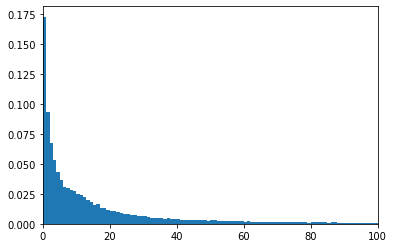

In [16]:
#### encoding de datos
df_rev.hours
plt.hist(x=df_rev.hours, bins=100, density=True, range=(0,100))
plt.xlim([0,100])

(0.0, 50.0)

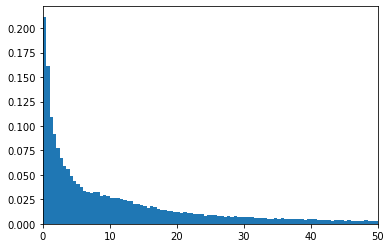

In [17]:
plt.hist(x=df_rev.hours, bins=100, density=True, range=(0,50))
plt.xlim([0,50])

In [18]:
## lo que tenemos aqui es sin duda una power law que vamos a encodear
## de una manera especial.
## normalizar con log
df_rev['log_hours'] = np.log(df_rev.hours)

(-10.0, 20.0)

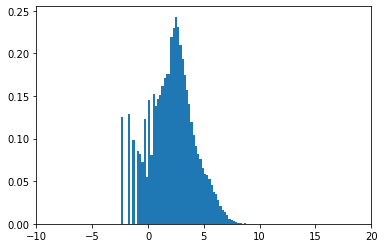

In [19]:
## escalado logaritmico
plt.hist(x=df_rev.log_hours, bins=100, density=True, range=(-10,10))
plt.xlim([-10,20])

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,10))
dataset = scaler.fit_transform(np.asarray(df_rev.log_hours).reshape(-1, 1))

In [21]:
df_rev['escalados'] = dataset

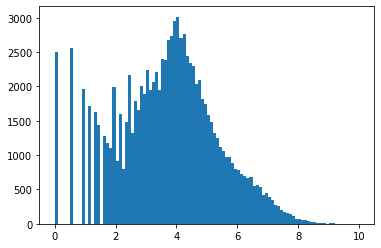

In [22]:
# quedan raros los datos
plt.hist(x=df_rev.escalados, bins=100)
plt.show()

In [23]:
#### meterlos al surprise
# from surprise import Reader, Dataset, SVD, accuracy
# from surprise.model_selection import cross_validate
# columnas user; item; rating; timestamp
# dataset  username; product_id; escalado; date
df_reader = df_rev[['username', 'product_id', 'escalados']] #date lacking
#df_reader.dropna(inplace=True)
df_reader_og = df_reader.copy()
df_reader

,username,product_id,escalados
0,Chaos Syren,725280,0.000000
1,₮ʜᴇ Wᴀʀᴛᴏɴ,328100,5.195230
2,hello?<,328100,4.151611
3,Cyderine916,35140,3.258925
4,DarklyThinking,35140,4.258560
...,...,...,...
99996,MatrixFluffy,291550,4.619430
99997,S A D,291550,6.404132
99998,Barney Fife,291550,4.233082
99999,MeltDown,233270,2.136740


In [24]:
array = df_reader.username.astype(str)

In [25]:
### encoding the names
from sklearn.preprocessing import OrdinalEncoder

le = OrdinalEncoder()
users = le.fit_transform(np.asarray(array).reshape(-1, 1))
users = users.astype(int)
df_reader.insert(0,'user', users)

In [26]:
df_reader = df_reader.drop(columns=['username'])

In [27]:
## disminuir esto de tamaño
#df_reader = df_reader[:50][
df_reader

,user,product_id,escalados
0,9915,725280,0.000000
1,83213,328100,5.195230
2,70080,328100,4.151611
3,12199,35140,3.258925
4,13355,35140,4.258560
...,...,...,...
99996,34394,291550,4.619430
99997,46184,291550,6.404132
99998,5953,291550,4.233082
99999,34931,233270,2.136740


In [28]:
reader = Reader(rating_scale=(1,10), line_format='user item rating')
data = Dataset.load_from_df(df_reader, reader=reader)

In [29]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25)

In [30]:
### cross validation
algo = SVD()
# Train the algorithm on the trainset, and predict ratings for the testset
# algo.fit(trainset)
# predictions = algo.test(testset)

# Then compute RMSE
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2321  1.2578  1.2489  1.2465  1.2444  1.2459  0.0083  
MAE (testset)     0.9206  0.9342  0.9292  0.9242  0.9252  0.9267  0.0046  
Fit time          5.12    5.27    5.42    5.17    5.17    5.23    0.11    
Test time         0.12    0.11    0.12    0.12    0.12    0.12    0.00    


{'test_rmse': array([1.23214007, 1.2578133 , 1.24885323, 1.2464641 , 1.24438825]),
 'test_mae': array([0.92062658, 0.93415311, 0.92916502, 0.92424668, 0.92522463]),
 'fit_time': (5.124151706695557,
  5.266050815582275,
  5.420219421386719,
  5.168162107467651,
  5.1691625118255615),
 'test_time': (0.11602640151977539,
  0.11402559280395508,
  0.11902713775634766,
  0.12002682685852051,
  0.11502671241760254)}

In [31]:
algo2 = SVD()
# Train the algorithm on the trainset, and predict ratings for the testset
algo2.fit(trainset)
predictions2 = algo.test(testset)

In [32]:
## el test solo predice lo que ya tiene un rating. No predice nada nuevo
predictions2

60', r_ui=3.451453188265577, est=2.96770654647389, details={'was_impossible': False}),
 Prediction(uid=8518, iid='291550', r_ui=4.638729285930328, est=4.753448220938024, details={'was_impossible': False}),
 Prediction(uid=46393, iid='427730', r_ui=3.681130957935372, est=3.2248608020029415, details={'was_impossible': False}),
 Prediction(uid=16081, iid='291550', r_ui=2.495605474976508, est=2.9543002175073707, details={'was_impossible': False}),
 Prediction(uid=26660, iid='388210', r_ui=3.2420948057775574, est=3.3960239363666527, details={'was_impossible': False}),
 Prediction(uid=45475, iid='427730', r_ui=2.0700603637919524, est=2.631898294519929, details={'was_impossible': False}),
 Prediction(uid=7875, iid='427730', r_ui=1.3407480038729551, est=2.666707261684703, details={'was_impossible': False}),
 Prediction(uid=61672, iid='296300', r_ui=3.0080880698310715, est=3.918715926531513, details={'was_impossible': False}),
 Prediction(uid=61037, iid='17430', r_ui=3.6504629460800615, est=3.2

In [33]:
from collections import defaultdict
from surprise import Dataset

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictionsn(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    ## see how many reviews they have
        if len(user_ratings) != 1:
            top_n[uid].append(f'p-{len(user_ratings)}') 

    return top_n


# First train an SVD algorithm on the movielens dataset.
# data = Dataset.load_builtin('ml-100k')
# trainset = data.build_full_trainset()
# algo = SVD()
# algo.fit(trainset)

# # Than predict ratings for all pairs (u, i) that are NOT in the training set.
# testset = trainset.build_anti_testset()
# predictions = algo.test(testset)



In [34]:
# top_n = get_top_n(predictions2, n=10)

# # Print the recommended items for each user
# # for uid, user_ratings in top_n.items():
# #     print(uid, [iid for (iid, _) in user_ratings])
# top_n

In [35]:
### definir funcion para que prediga un numero de peliculas al azar
### con el dataset
import random
from icecream import ic
def predecir(dataset,
            algo,
            n_random_games=15,
            n_random_users=50,
            top=5,
            game_ids=0,
            user_ids=0,
            predicts=10):
    '''
    Esta funcion crea un diccionario con predicciones que los usuarios no han 
        rateado.
    - num_predicts: es el numero de predicciones que hacer para cada usuario
    - user_ids: el id de las personas, si rand_users es True, no hay que poner            user_ids.
    - rand_users: si coger a usuers al azar para hacer predicciones.
    - dataset: el dataset con las predicciones con las que se entrena el modelo. en       nuestro caso "df_reader".
    - algo: el algoritmo que se va a use. En nuesto caso "algo2".
    '''
    predicted = defaultdict(list)
    ## if the input is empty or 0 get random get random items
    total_games = len(dataset.product_id.value_counts().index)
    total_users = len(dataset.user.value_counts().index)
    if game_ids==0:
        if n_random_games > total_games:
            n_random_games = total_games
        j = dataset.product_id.value_counts().index
        game_ids=random.sample(list(j), n_random_games)
    if user_ids==0:
        if n_random_users > total_users:
            n_random_users = toatl_users
        u = dataset.user.value_counts().index
        user_ids = random.sample(list(u), n_random_users)

    ### loop trough users and games and append to 'predicted'
    for user in user_ids:
        for game in game_ids:
            ## skipear si ya habia rateado el juego
            v = dataset.loc[(dataset.user == user) & (dataset.product_id == game)]
            if len(v) == 0:
                ## predict and append the predictions
                pred = algo2.predict(user, game)
                predicted[pred[0]].append((pred[1],pred[3]))

    # sort the predictions for each user
    for uid, user_ratings in predicted.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        predicted[uid] = user_ratings[:top]

    return predicted



- Mirar si hay correlación entre categorías de juegos recomendados según las predicciones encontradas
- Agregar datos al dataset 
- eliminar duplicados

In [36]:
    df_games.loc[df_games.id == str(344340)]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
27465,Solecismic Software,"[Indie, Simulation, Sports, Strategy]",Front Office Football Seven,Front Office Football Seven,http://store.steampowered.com/app/344340/Front...,2014-11-21,"[Sports, Simulation, Strategy, Indie, Manageme...",NaN,http://steamcommunity.com/app/344340/reviews/?...,"[Single-player, Multi-player, Steam Achievements]",18.99,False,344340,Solecismic Software,Very Positive,NaN


In [37]:
def traducir(preds):
    for user in preds:
        ## coger el username por medio de los indices
        index_num_user = df_reader.loc[df_reader.user == user].index
        username = df_reader_og.iloc[index_num_user]
        ## coger el titulo del juego
        for user.
        juego_id = preds[user][0][0]
        df_reader.loc[df_games.id =  ]


SyntaxError: invalid syntax (<ipython-input-37-321e7944645c>, line 7)

In [ ]:
"""
Funcion que traduce y crea un data frame yq ue lo guarda localmente
Organizar todo y ver que mas falta
"""